In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/orion/projects/RDaly2023/MCMC-fitting/Merloni+03/MerloniAGN.csv', 
                 header=0, usecols=[2,3,4,5,6,7])
df

,Log(L_R),Log(L_X),Log M,Log(L_EDD),Log(L_j),Log(Lbol}
0,38.59,43.74,6.50,44.6139,43.564204,44.92
1,41.43,44.22,9.40,47.5139,45.622068,45.40
2,39.71,40.66,9.00,47.1139,44.375756,41.84
3,39.68,41.20,9.10,47.2139,44.354018,42.38
4,38.94,43.72,6.69,44.8039,43.817814,44.90
...,...,...,...,...,...,...
75,39.75,44.34,8.38,46.4939,44.404740,45.52
76,38.89,43.55,8.16,46.2739,43.781584,44.73
77,41.55,43.95,7.36,45.4739,45.709020,45.13
78,41.09,44.00,8.53,46.6439,45.375704,45.18


In [3]:
df.rename(columns={'Log(L_R)':'logR', 'Log(L_X)': 'logX', 'Log(L_j)' : 'logLj'}, inplace=True)

Text(0, 0.5, 'log Lj')

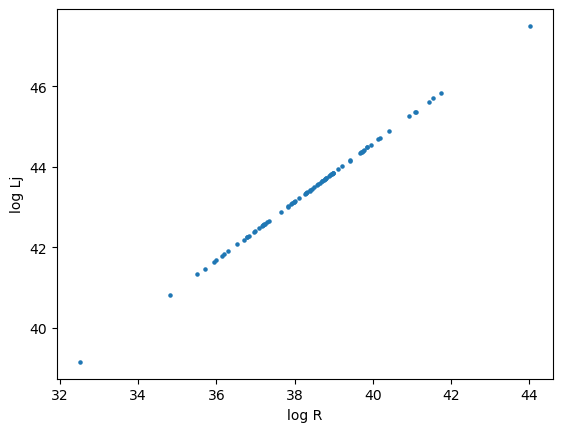

In [4]:
plt.scatter(df['logR'], df['logLj'], s=5)
plt.xlabel('log R')
plt.ylabel('log Lj')

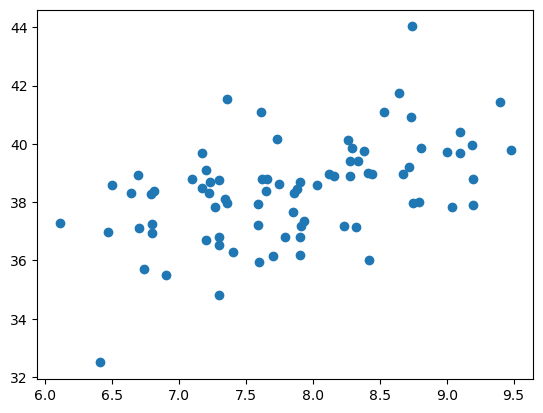

In [5]:
plt.scatter(df['Log M'], df['logR'])

In [6]:
#  linear fit:  y = C * x + D
#  y = logLj   ,   x = logR

In [7]:
def statmodel_fit(x, y):

    x = sm.add_constant(x) # adding a constant
 
    model = sm.OLS(y, x).fit()
    predictions = model.predict(x) 
 
    print_model = model.summary()
    print(print_model)

In [8]:
xaxis = df['logR']
yaxis = df['logLj']

statmodel_fit(xaxis, yaxis)

                            OLS Regression Results                            
Dep. Variable:                  logLj   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.335e+30
Date:                Sun, 24 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:36:35   Log-Likelihood:                 2491.7
No. Observations:                  80   AIC:                            -4979.
Df Residuals:                      78   BIC:                            -4975.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.6019   1.82e-14   8.56e+14      0.0

In [9]:
#true values 

m_true = 0.7
c_true = 15.6
f_true = 0.1

In [10]:
df['logR_err'] = df['logR'].std()

x = df['logR']
y = df['logLj']
yerr = m_true*df['logR_err']

In [11]:
def log_likelihood(theta, x, y, yerr):
    m, c, log_f = theta
    model = m*x + c              
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [13]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, c_true, np.log(f_true)]) + 0.1 * np.random.randn(3)


soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, const_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("C = {0:.3f}".format(m_ml))
print("D = {0:.3f}".format(const_ml))
print("log_f = {0:.3f}".format(log_f_ml))     


Maximum likelihood estimates:
C = 0.725
D = 15.602
log_f = -14.011


In [30]:
# MCMC

In [17]:
def log_prior(theta):
    m, c, log_f = theta
    
    # use max-likelihood fit results to predict the range of params
    if -0.5 < m < 1.5 and -5.0 < c < 25.0 and -25.0 < log_f < 5.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [15]:
pos = soln.x + 0.05 * np.random.randn(30, 3)
nwalkers, ndim = pos.shape

print(nwalkers, ndim)

32 3


In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 500, progress=True);          #the colon prevents hidden print command apparently

100%|██████████████████████████████████████████████| 500/500 [00:12<00:00, 39.27it/s]


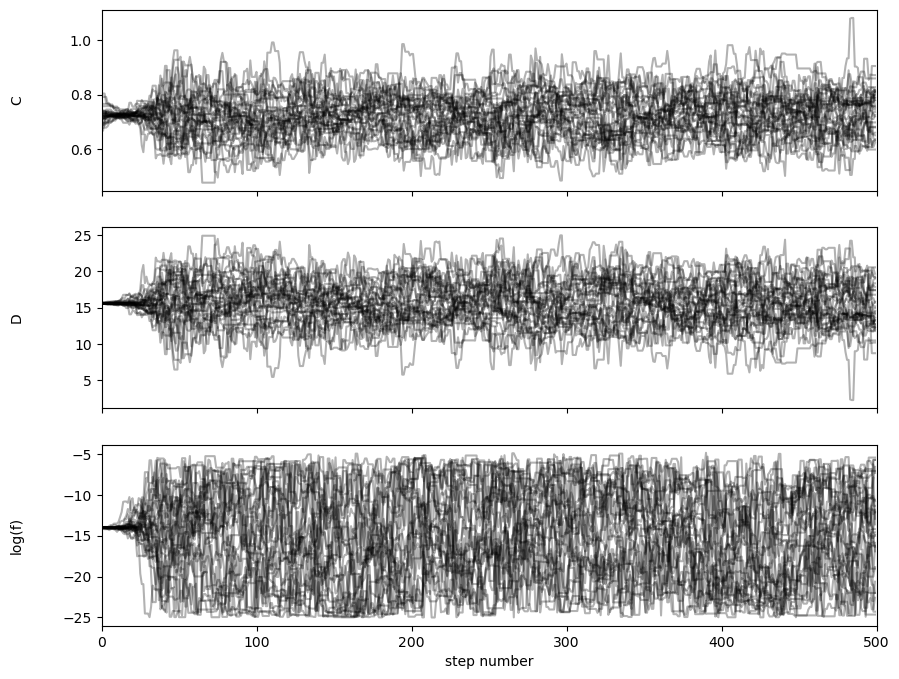

In [18]:
fig, axes = plt.subplots(3, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["C", "D", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [19]:
sampler.reset()
sampler.run_mcmc(pos, 3000, progress=True);

100%|████████████████████████████████████████████| 3000/3000 [01:16<00:00, 39.30it/s]


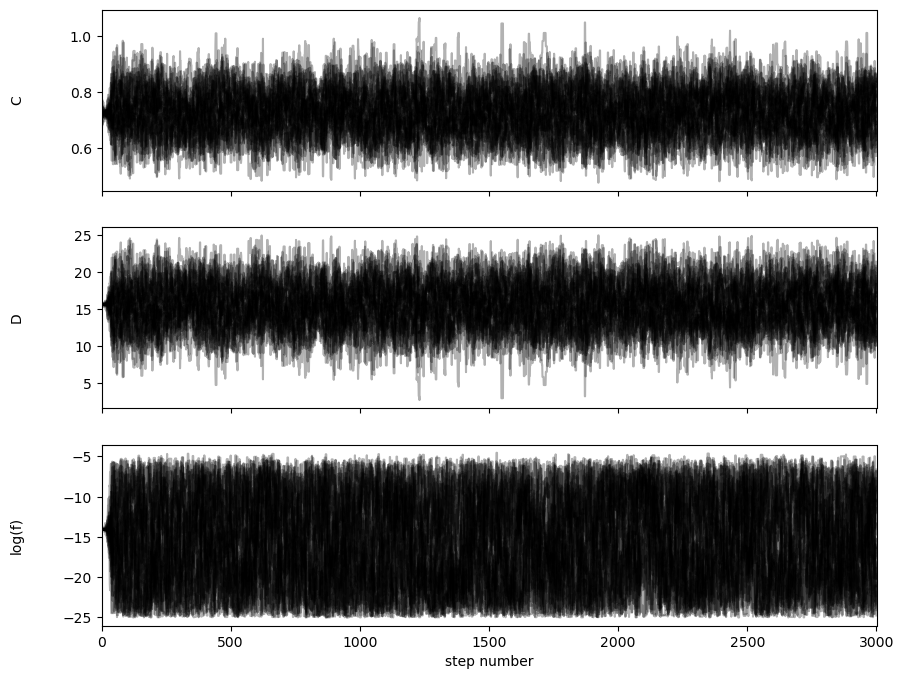

In [20]:
fig, axes = plt.subplots(3, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["C", "D", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(5312, 3)


In [22]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
print(sample)

[ 0.6728778  17.3442987  -7.62266358]


In [23]:
for ind in inds:
    sample = flat_samples[ind]
    print(sample)

[  0.67703419  17.35328659 -12.79900774]
[  0.63863473  18.66593946 -20.15255668]
[  0.76721389  14.02521774 -21.27995472]
[  0.62704435  19.39914481 -14.74906502]
[ 0.60983347 19.83480615 -9.23518896]
[  0.65441707  18.23458326 -10.46909145]
[  0.81829117  11.90288169 -22.97199119]
[  0.69913134  16.36381952 -15.99821526]
[ 0.57654197 21.22419755 -8.57509163]
[  0.77748914  13.57590907 -19.19250877]
[ 0.76501835 14.26063674 -5.48932525]
[  0.84889762  10.92958075 -13.92292602]
[  0.7220328   15.72993908 -21.28144639]
[  0.81639421  12.34282797 -17.85116994]
[  0.60736311  20.06451128 -12.82252649]
[  0.91133692   8.50874503 -22.99213492]
[  0.73054774  15.4809998  -14.92234179]
[  0.66810268  18.22433496 -24.90444919]
[  0.77102983  13.76565261 -12.53008664]
[  0.59436371  20.64246079 -22.3998633 ]
[  0.68099372  17.18122916 -23.0380919 ]
[  0.74942342  14.60364517 -23.26595751]
[  0.68179237  17.11770596 -10.62315747]
[  0.62701223  19.27423627 -17.94768718]
[ 0.81867141 12.05456194 

In [24]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [10, 50, 90])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

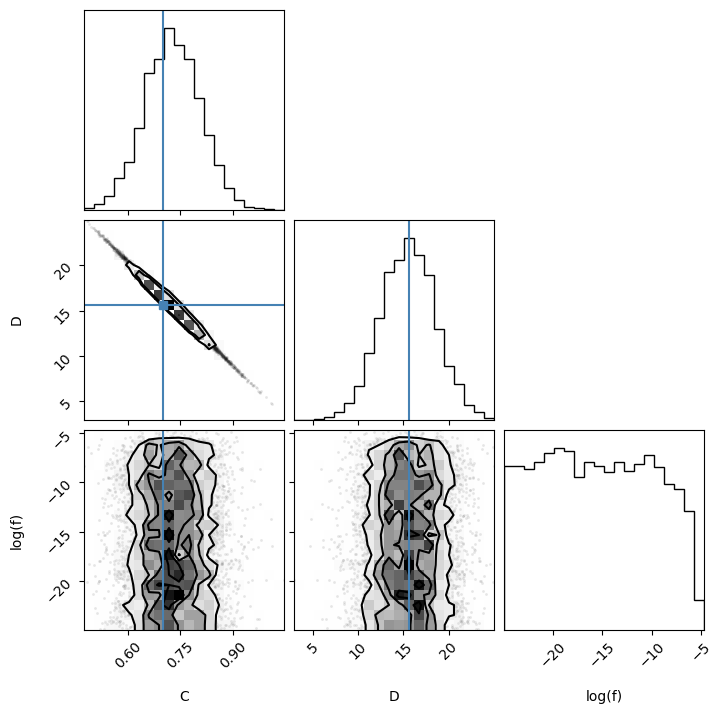

In [25]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, c_true, np.log(f_true)]
)

In [12]:
yerr

0     1.20989
1     1.20989
2     1.20989
3     1.20989
4     1.20989
       ...   
75    1.20989
76    1.20989
77    1.20989
78    1.20989
79    1.20989
Name: logR_err, Length: 80, dtype: float64

In [13]:
# check column multiplication

df['logR_err'] = df['logR'].std()
print(df['logR_err'], df['logR'])
print(df['logR_err']*df['logR'])

0     1.728414
1     1.728414
2     1.728414
3     1.728414
4     1.728414
        ...   
75    1.728414
76    1.728414
77    1.728414
78    1.728414
79    1.728414
Name: logR_err, Length: 80, dtype: float64 0     38.59
1     41.43
2     39.71
3     39.68
4     38.94
      ...  
75    39.75
76    38.89
77    41.55
78    41.09
79    32.50
Name: logR, Length: 80, dtype: float64
0     66.699498
1     71.608194
2     68.635322
3     68.583469
4     67.304443
        ...    
75    68.704458
76    67.218022
77    71.815604
78    71.020533
79    56.173457
Length: 80, dtype: float64


In [ ]:
#  to find: error in y -- delta_logLj 
#  logLj =  C logR + D


In [14]:
# using upper bound on slope uncertainty delta_C
d_C = 0.062
C_true = 0.7

In [19]:
df['logR_err'] = df['logR'].std()
df['d_logLj'] =  np.sqrt((d_C/C_true)**2  +  (df['logR_err']/df['logR'])**2)

In [21]:
df['d_logLj']#*df['logLj']

0     0.099252
1     0.097905
2     0.098688
3     0.098703
4     0.099071
        ...   
75    0.098669
76    0.099097
77    0.097854
78    0.098052
79    0.103311
Name: d_logLj, Length: 80, dtype: float64

In [22]:
df['d_logLj']*df['logLj']    #delta_logLj 

0     4.323836
1     4.466623
2     4.379373
3     4.377872
4     4.341076
        ...   
75    4.381376
76    4.338606
77    4.472792
78    4.449200
79    4.044780
Length: 80, dtype: float64

In [ ]:
# delta_logLj ==> 'logLj_err'

In [21]:
df['logLj_err'] =  np.round(df['logLj']*np.sqrt((d_C/C_true)**2  +  (df['logR_err']/df['logR'])**2), 2)

In [22]:
df

,logR,logX,Log M,Log(L_EDD),logLj,Log(Lbol},logR_err,logLj_err
0,38.59,43.74,6.50,44.6139,43.564204,44.92,1.728414,4.32
1,41.43,44.22,9.40,47.5139,45.622068,45.40,1.728414,4.47
2,39.71,40.66,9.00,47.1139,44.375756,41.84,1.728414,4.38
3,39.68,41.20,9.10,47.2139,44.354018,42.38,1.728414,4.38
4,38.94,43.72,6.69,44.8039,43.817814,44.90,1.728414,4.34
...,...,...,...,...,...,...,...,...
75,39.75,44.34,8.38,46.4939,44.404740,45.52,1.728414,4.38
76,38.89,43.55,8.16,46.2739,43.781584,44.73,1.728414,4.34
77,41.55,43.95,7.36,45.4739,45.709020,45.13,1.728414,4.47
78,41.09,44.00,8.53,46.6439,45.375704,45.18,1.728414,4.45


In [23]:
df.to_csv('MerloniAGN_Ljerrors.csv', header=True)